Thermal coupling data. Hourly data not independent. Consider the difference, turn it into one series. The difference will hopefully start off looking like zero. This also removes the different SDs and whatnot. Change Detection on Wikipedia. The mean difference should be zero, but then will move away from zero. Does the difference go from flat, to linearly increasing, to maybe exponential? We're dealing with offline change detection. Make sure to plot the difference. Could also chunk up the data. Change in first couple years? Then check the next.

Could probably use detection algorithm, to see when that change is. 

Once we decide to use all 8 models, should stick to pairwise comparisons. 

Can also focus on top 5% of values and their differences. When do the peaks start to separate?

Hypothesis test of change vs no change. Likelihood ratio something something? We want to reduce some autocorrelation by taking fewer temps e.g. only at 4pm

The differences should look a bit normal.

In [3]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import glob

from pathlib import Path

import scipy.stats as stats

from scipy import stats

In [72]:
# create function that takes BA and number of years, then outputs a plot or dataframe of their differences
def diff_values(input_BA, num_years): # input input_BA as string e.g. 'AEC' and num_years as integer 1-80
    
    # get a list of files based on input_BA and num_years to read in
    list_of_hot_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_HOT\CONUS_TGW_WRF_SSP585_HOT', f'{input_BA}_*.csv'))
    list_num_hot_files = list_of_hot_files[0 : num_years]
    list_of_cold_files = glob.glob(os.path.join(r'C:\projects\CONUS_TGW_WRF_SSP585_COLD\CONUS_TGW_WRF_SSP585_COLD', f'{input_BA}_*.csv'))
    list_num_cold_files = list_of_cold_files[0 : num_years]
    
    # create a dataframe of their differences
    for file_index in range(len(list_num_hot_files)):
        
        # read in each year as df
        hot_year_df = pd.read_csv(list_num_hot_files[file_index], index_col = None, header = 0)
        cold_year_df = pd.read_csv(list_num_cold_files[file_index], index_col = None, header = 0)
        
        # get difference values
        diff_values = hot_year_df['T2'] - cold_year_df['T2']
        diff_values_array = np.asarray(diff_values)
        diff_year_df = pd.DataFrame(diff_values_array, columns = ['T2_Differences'])

        if file_index == 0:
            diff_df = diff_year_df
        else: diff_df = pd.concat([diff_df, diff_year_df])
    
    plt.figure(figsize=(25, 10))
    plt.plot(diff_df, color = "red")
    plt.ylabel('T2 Difference')
    plt.title(input_BA + ' Temperature Differences over ' + str(num_years) + ' years')
    
    return diff_df

,T2_Differences
0,-0.01
1,-0.13
2,-0.11
3,-0.08
4,-0.23
...,...
8778,0.37
8779,0.33
8780,0.30
8781,0.35


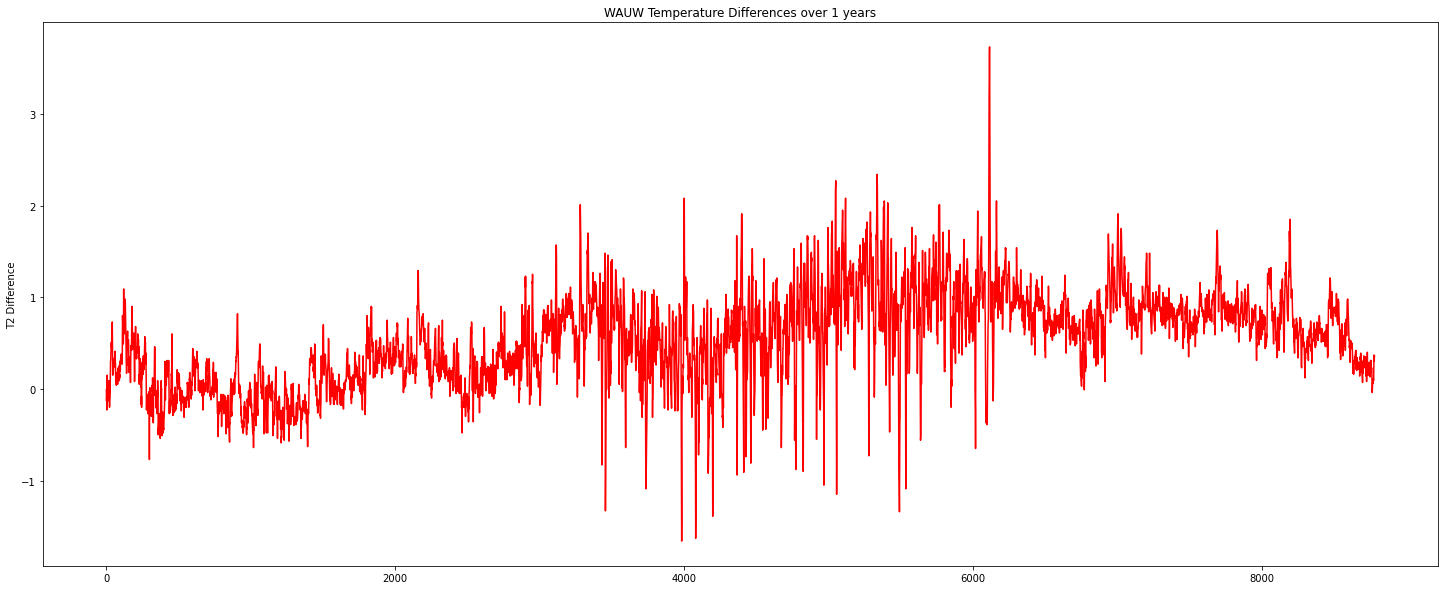

In [73]:
diff_values('WAUW', 1)